#  6 Variational AutoEncoder

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x:torch.flatten(x))])

train_set = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

train_loader = DataLoader(train_set,batch_size=128,shuffle=True)

test_set = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

In [3]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE,self).__init__()

        self.encoder = nn.Sequential(nn.Linear(input_dim,hidden_dim),
                                     nn.ReLU(),
                                     nn.Linear(hidden_dim, hidden_dim),
                                     nn.ReLU())
        
        self.mu = nn.Linear(hidden_dim,latent_dim)
        self.log_var = nn.Linear(hidden_dim,latent_dim)

        self.decoder = nn.Sequential(nn.Linear(latent_dim,hidden_dim),
                                     nn.ReLU(),
                                     nn.Linear(hidden_dim,input_dim),
                                     nn.Sigmoid())
    
    def encode(self,x):
        h = self.encoder(x)
        mu = self.mu(h)
        log_var = self.log_var(h)
        return mu, log_var
    
    def reparameterize(self,mu,log_var):
        std=torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return mu+eps*std
    
    def decode(self,z):
        return self.decoder(z)
    
    #loss functions
    @staticmethod
    def loss_fn(x_reconstruct,x,mu,log_var):
        #BCE
        reconstruct_loss = nn.functional.binary_cross_entropy(x_reconstruct,x,reduction='sum')
        
        #KL divergence
        kl_divergence = -0.5 * torch.sum(1+log_var-mu.pow(2)-log_var.exp())

        return reconstruct_loss+kl_divergence
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconstructed = self.decode(z)
        return x_reconstructed, mu, log_var
    


In [4]:
input_dim = 28*28
hidden_dim = 512
latent_dim = 32

vae = VAE(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

num_epochs = 10
vae.train()

for epoch in range(num_epochs):
    total_loss = 0
    
    for x, _ in train_loader:
        x = x.view(-1, input_dim)  
  
        x_reconstructed, mu, log_var = vae(x)

        loss = VAE.loss_fn(x_reconstructed, x, mu, log_var)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader.dataset):.4f}")

Epoch [1/10], Loss: 167.6019
Epoch [2/10], Loss: 125.3077
Epoch [3/10], Loss: 116.0163
Epoch [4/10], Loss: 111.9986
Epoch [5/10], Loss: 109.6915
Epoch [6/10], Loss: 108.3090
Epoch [7/10], Loss: 107.2178
Epoch [8/10], Loss: 106.5088
Epoch [9/10], Loss: 105.8622
Epoch [10/10], Loss: 105.4237


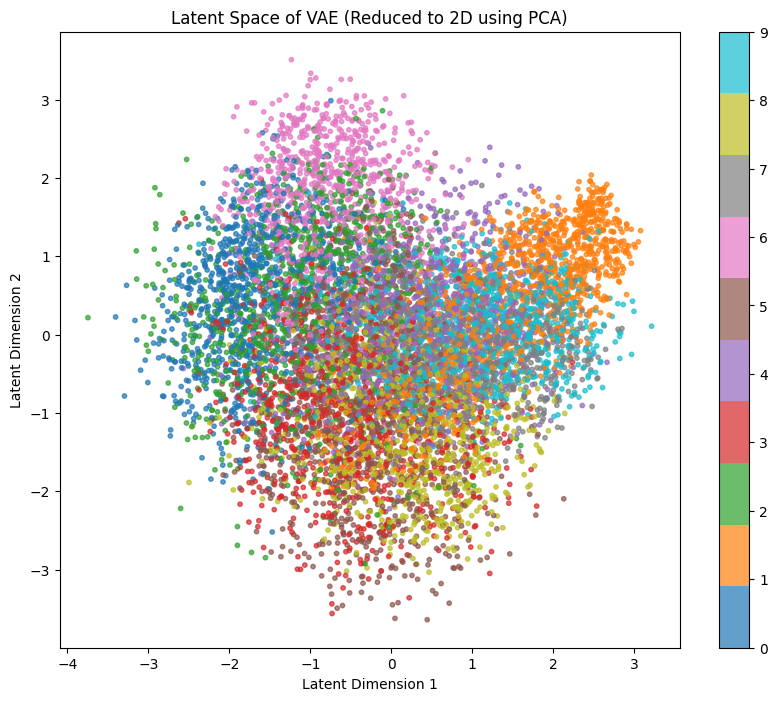

In [5]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch

vae.eval()

latent_means = []
labels = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.view(-1, input_dim)
        mu, log_var = vae.encode(x)
        latent_means.append(mu)
        labels.append(y)

latent_means = torch.cat(latent_means).cpu().numpy()
labels = torch.cat(labels).cpu().numpy()

pca = PCA(n_components=2)
reduced_means = pca.fit_transform(latent_means)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_means[:, 0], reduced_means[:, 1], c=labels, cmap='tab10', alpha=0.7, s=10)
plt.colorbar(scatter, ticks=range(10))
plt.title('Latent Space of VAE (Reduced to 2D using PCA)')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.show()


Epoch [1/15], Loss: 0.00035522500425577165
Epoch [2/15], Loss: 0.00023456507374842962
Epoch [3/15], Loss: 0.00016305990070104599
Epoch [4/15], Loss: 0.00013513154188791912
Epoch [5/15], Loss: 0.00010099769532680512
Epoch [6/15], Loss: 0.00010034237901369731
Epoch [7/15], Loss: 6.823711097240447e-05
Epoch [8/15], Loss: 8.439669559399287e-05
Epoch [9/15], Loss: 8.26276421546936e-05
Epoch [10/15], Loss: 6.583739668130875e-05
Epoch [11/15], Loss: 5.6130991876125334e-05
Epoch [12/15], Loss: 7.815701166788736e-05
Epoch [13/15], Loss: 6.980490734179814e-05
Epoch [14/15], Loss: 7.907842596371969e-05
Epoch [15/15], Loss: 2.273634821176529e-05


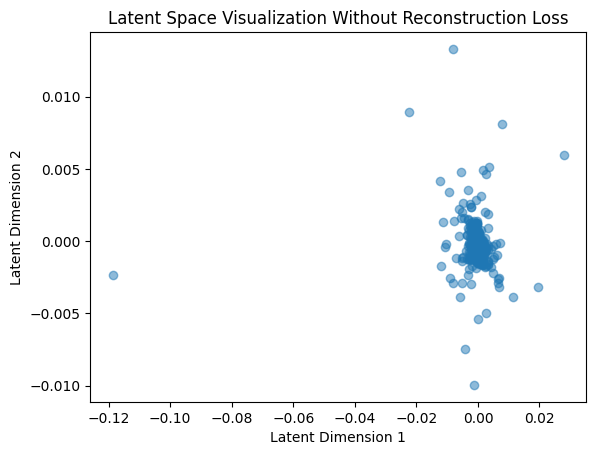

In [18]:
def loss_fn_no_recon(x_reconstructed, x, mu, log_var):
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return kl_loss

num_epochs = 15
vae.train()

for epoch in range(num_epochs):
    total_loss = 0
    
    for x, _ in train_loader:
        x = x.view(-1, input_dim)  
        x_reconstructed, mu, log_var = vae(x)

        loss = loss_fn_no_recon(x_reconstructed, x, mu, log_var)  # Only KL loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader.dataset):}")


vae.eval()
latent_means = []

with torch.no_grad():
    for x, _ in test_loader:
        x = x.view(-1, input_dim)
        _, mu, _ = vae(x)
        latent_means.append(mu.numpy())

latent_means = np.concatenate(latent_means, axis=0)

plt.scatter(latent_means[:, 0], latent_means[:, 1], alpha=0.5)
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("Latent Space Visualization Without Reconstruction Loss")
plt.show()

Epoch [1/15], Loss: 2.4831
Epoch [2/15], Loss: 2.4195
Epoch [3/15], Loss: 2.3658
Epoch [4/15], Loss: 2.2983
Epoch [5/15], Loss: 2.2478
Epoch [6/15], Loss: 2.1963
Epoch [7/15], Loss: 2.1523
Epoch [8/15], Loss: 2.0997
Epoch [9/15], Loss: 2.0680
Epoch [10/15], Loss: 2.0296
Epoch [11/15], Loss: 1.9953
Epoch [12/15], Loss: 1.9591
Epoch [13/15], Loss: 1.9296
Epoch [14/15], Loss: 1.9043
Epoch [15/15], Loss: 1.8752


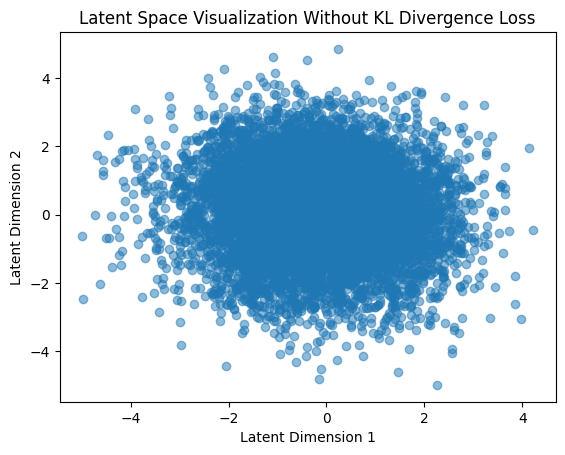

In [21]:
def loss_fn_no_kl(x_reconstructed, x, mu, log_var):
    recon_loss = torch.nn.functional.mse_loss(x_reconstructed, x, reduction='sum')
    return recon_loss
num_epochs = 15
vae.train()

for epoch in range(num_epochs):
    total_loss = 0
    
    for x, _ in train_loader:
        x = x.view(-1, input_dim)  
        x_reconstructed, mu, log_var = vae(x)

        loss = loss_fn_no_kl(x_reconstructed, x, mu, log_var)  # Only reconstruction loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader.dataset):.4f}")

vae.eval()
latent_means = []

with torch.no_grad():
    for x, _ in test_loader:
        x = x.view(-1, input_dim)
        _, mu, _ = vae(x)
        latent_means.append(mu.numpy())

latent_means = np.concatenate(latent_means, axis=0)

plt.scatter(latent_means[:, 0], latent_means[:, 1], alpha=0.5)
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("Latent Space Visualization Without KL Divergence Loss")
plt.show()

### Observations:
#### Reconstruction-Loss importance
- Reconstruction Loss (e.g., Binary Cross-Entropy or Mean Squared Error) ensures that the output of the decoder closely matches the original input.
-  If we remove the reconstruction loss: The model will not learn to generate meaningful outputs and latent space collapse into a meaningless representation.
- The decoded images will be random noise instead of structured outputs and VAE focus on regularizing the latent space without ensuring useful reconstructions.

#### KL-Divergence-Loss importance
- KL Divergence Loss ensures that the learned latent space follows a Gaussian distribution, enabling smooth sampling and meaningful interpolation.
-  If we remove the KL divergence loss: The VAE will act more like an autoencoder, memorizing inputs instead of learning a structured latent space.
- The latent space might be discontinuous or sparse, making it harder to generate meaningful variations.

Epoch [1/15], Loss: 184.9528
Epoch [2/15], Loss: 163.1585
Epoch [3/15], Loss: 159.0767
Epoch [4/15], Loss: 156.9807
Epoch [5/15], Loss: 155.2275
Epoch [6/15], Loss: 153.8068
Epoch [7/15], Loss: 152.7127
Epoch [8/15], Loss: 151.8497
Epoch [9/15], Loss: 150.9829
Epoch [10/15], Loss: 150.1226
Epoch [11/15], Loss: 149.5312
Epoch [12/15], Loss: 149.2127
Epoch [13/15], Loss: 148.5647
Epoch [14/15], Loss: 148.3095
Epoch [15/15], Loss: 148.0106


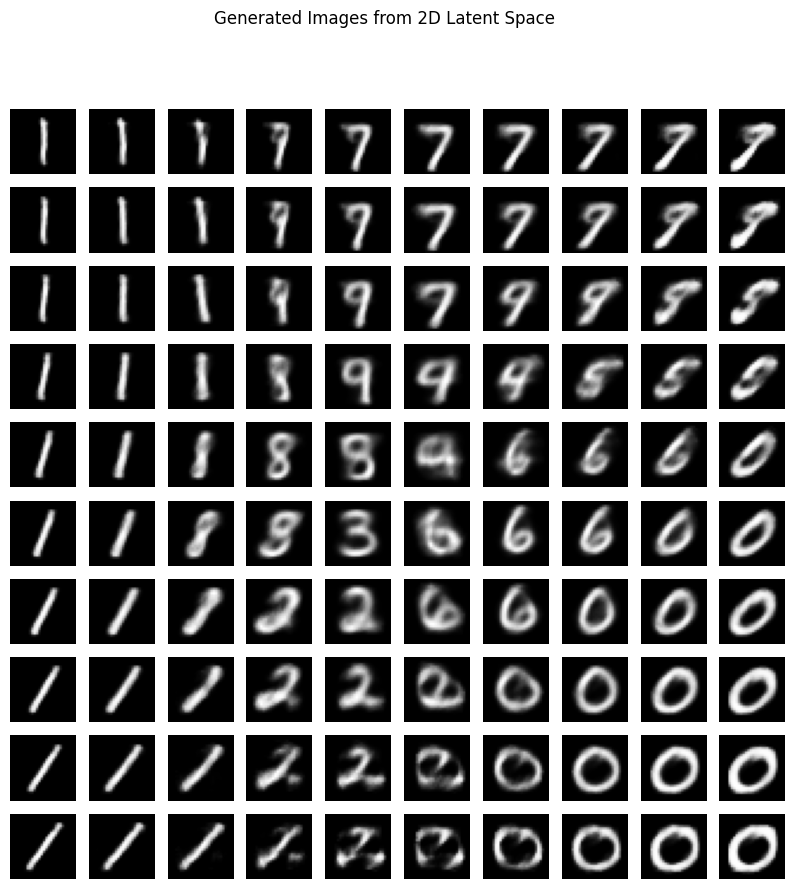

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
input_dim = 28*28
hidden_dim = 512
latent_dim = 2

vae = VAE(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

num_epochs = 15
vae.train()

for epoch in range(num_epochs):
    total_loss = 0
    
    for x, _ in train_loader:
        x = x.view(-1, input_dim)  
  
        x_reconstructed, mu, log_var = vae(x)

        loss = VAE.loss_fn(x_reconstructed, x, mu, log_var)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader.dataset):.4f}")

vae.eval()

grid_size = 10

z1 = np.linspace(-3, 3, grid_size)
z2 = np.linspace(-3, 3, grid_size)
z1, z2 = np.meshgrid(z1, z2)

z = np.vstack([z1.ravel(), z2.ravel()]).T
z = torch.tensor(z, dtype=torch.float32)

with torch.no_grad():
    generated_images = vae.decode(z).view(-1, 1, 28, 28)

# Plot 
fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
for i in range(grid_size):
    for j in range(grid_size):
        axes[i, j].imshow(generated_images[i * grid_size + j].squeeze(), cmap='gray')
        axes[i, j].axis('off')

plt.suptitle('Generated Images from 2D Latent Space')
plt.show()


Epoch [1/15], Loss: 47.8969
Epoch [2/15], Loss: 41.5144
Epoch [3/15], Loss: 40.3456
Epoch [4/15], Loss: 39.6434
Epoch [5/15], Loss: 39.1644
Epoch [6/15], Loss: 38.7936
Epoch [7/15], Loss: 38.4929
Epoch [8/15], Loss: 38.2273
Epoch [9/15], Loss: 37.9963
Epoch [10/15], Loss: 37.7845
Epoch [11/15], Loss: 37.5739
Epoch [12/15], Loss: 37.4643
Epoch [13/15], Loss: 37.2793
Epoch [14/15], Loss: 37.1292
Epoch [15/15], Loss: 36.9769


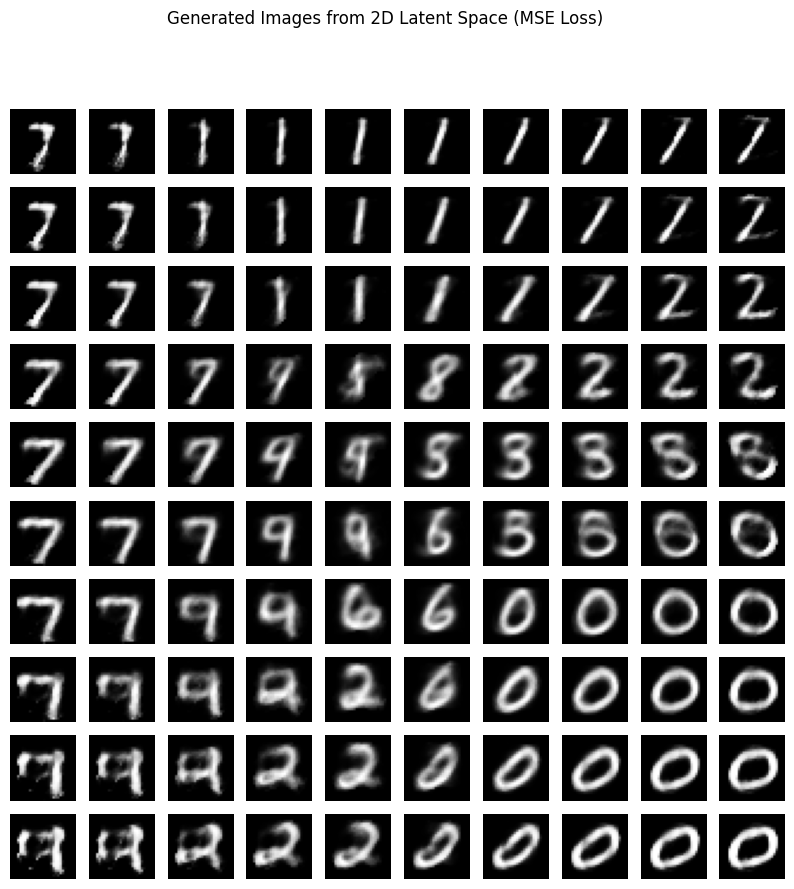

In [25]:
import torch.nn.functional as F

def mse_loss_fn(x_reconstructed, x, mu, log_var):
    reconstruction_loss = F.mse_loss(x_reconstructed, x, reduction='sum')

    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    loss = reconstruction_loss + kl_divergence
    return loss

import torch
import torch.optim as optim

vae = VAE(input_dim, hidden_dim, latent_dim=2)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

num_epochs = 15
vae.train()

for epoch in range(num_epochs):
    total_loss = 0
    
    for x, _ in train_loader:
        x = x.view(-1, input_dim)
      
        x_reconstructed, mu, log_var = vae(x)

        loss = mse_loss_fn(x_reconstructed, x, mu, log_var)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader.dataset):.4f}")


vae.eval()

grid_size = 10
z1 = np.linspace(-3, 3, grid_size)
z2 = np.linspace(-3, 3, grid_size)
z1, z2 = np.meshgrid(z1, z2)

z = np.vstack([z1.ravel(), z2.ravel()]).T
z = torch.tensor(z, dtype=torch.float32)

with torch.no_grad():
    generated_images = vae.decode(z).view(-1, 1, 28, 28)

# Plot
fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
for i in range(grid_size):
    for j in range(grid_size):
        axes[i, j].imshow(generated_images[i * grid_size + j].squeeze(), cmap='gray')
        axes[i, j].axis('off')

plt.suptitle('Generated Images from 2D Latent Space (MSE Loss)')
plt.show()

## Observations
### Case 1: Using Binary Cross-Entropy (BCE) Loss
- The reconstructed images are sharp and well-defined.  The transition between images across the grid is smooth and continuous.
- The latent space is comparitively well-structured, allowing proper interpolation between different data points.
- BCE loss treats each pixel as a probability (0 or 1), making it ideal for binary images like MNIST digits. Encourages the VAE to capture meaningful patterns and sharp reconstructions.

### Case 2: Using Mean Squared Error (MSE) Loss
- The reconstructed images appear blurrier compared to BCE loss. Some variations in the latent space are less structured, leading to distorted or mixed images.
- The transitions between images are still continuous, but less sharp than in BCE case. The model struggles with fine details, resulting in loss of clarity in reconstructed outputs.
- MSE loss minimizes pixel-wise intensity differences, which can lead to blurry reconstructions.It treats pixel values as continuous, rather than probabilities, making it less suitable for binary-like images